In [3]:
import pandas as pd
import zipfile
import os

# Load the dataset
try:
    zip_path = '/content/dataset.zip'
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Assuming the relevant data is in a .pkl file within the zip
        # We'll look for the first .pkl file and read it
        pkl_files = [f for f in zip_ref.namelist() if f.endswith('.pkl')]
        if pkl_files:
            # Extract the file to a temporary location and read it
            extracted_file_path = zip_ref.extract(pkl_files[0], '/tmp/')
            df = pd.read_pickle(extracted_file_path)
            print("Dataset loaded successfully!")
            print("First 5 rows of the dataset:")
            display(df.head())
            # Clean up the extracted file
            os.remove(extracted_file_path)
        else:
            print("No .pkl files found in the zip archive.")

except FileNotFoundError:
    print(f"Error: The file {zip_path} was not found. Please make sure the file is in the correct directory.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

Dataset loaded successfully!
First 5 rows of the dataset:


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [5]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check data types
print("\nData types of each column:")
print(df.dtypes)

# Check the distribution of the target variable (TX_FRAUD)
print("\nDistribution of fraudulent vs. non-fraudulent transactions:")
print(df['TX_FRAUD'].value_counts())

# Display the percentage of fraudulent transactions
print("\nPercentage of fraudulent transactions:")
print(df['TX_FRAUD'].value_counts(normalize=True) * 100)


Missing values per column:
TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64

Data types of each column:
TRANSACTION_ID                int64
TX_DATETIME          datetime64[ns]
CUSTOMER_ID                  object
TERMINAL_ID                  object
TX_AMOUNT                   float64
TX_TIME_SECONDS              object
TX_TIME_DAYS                 object
TX_FRAUD                      int64
TX_FRAUD_SCENARIO             int64
dtype: object

Distribution of fraudulent vs. non-fraudulent transactions:
TX_FRAUD
0    9485
1       3
Name: count, dtype: int64

Percentage of fraudulent transactions:
TX_FRAUD
0    99.968381
1     0.031619
Name: proportion, dtype: float64


In [6]:
# Feature Engineering

# Convert 'TX_DATETIME' to datetime objects if not already
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

# Extract features from TX_DATETIME
df['TX_HOUR'] = df['TX_DATETIME'].dt.hour
df['TX_DAY_OF_WEEK'] = df['TX_DATETIME'].dt.dayofweek
df['TX_DAY'] = df['TX_DATETIME'].dt.day
df['TX_WEEK'] = df['TX_DATETIME'].dt.isocalendar().week.astype(int)
df['TX_MONTH'] = df['TX_DATETIME'].dt.month
df['TX_YEAR'] = df['TX_DATETIME'].dt.year

# Create simple velocity features (number of transactions in a time window)
# This is a simplified example, more robust velocity features would require sorting by time and grouping
# For a beginner-friendly approach, we'll skip complex time-windowed features for now.

# Simple count of transactions per customer and terminal (can be indicative of unusual activity)
customer_tx_counts = df['CUSTOMER_ID'].value_counts().rename('customer_tx_count')
df = df.join(customer_tx_counts, on='CUSTOMER_ID')

terminal_tx_counts = df['TERMINAL_ID'].value_counts().rename('terminal_tx_count')
df = df.join(terminal_tx_counts, on='TERMINAL_ID')

print("Features engineered successfully!")
print("DataFrame with new features:")
display(df.head())

Features engineered successfully!
DataFrame with new features:


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_HOUR,TX_DAY_OF_WEEK,TX_DAY,TX_WEEK,TX_MONTH,TX_YEAR,customer_tx_count,terminal_tx_count
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0,0,6,1,13,4,2018,4,2
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0,0,6,1,13,4,2018,6,3
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0,0,6,1,13,4,2018,1,3
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0,0,6,1,13,4,2018,5,2
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0,0,6,1,13,4,2018,3,1


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define features and target
# Exclude 'TRANSACTION_ID', 'TX_DATETIME', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', and 'TX_FRAUD_SCENARIO'
# as they are not suitable as direct features or are related to the target/simulation
features = ['CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_HOUR',
            'TX_DAY_OF_WEEK', 'TX_DAY', 'TX_WEEK', 'TX_MONTH', 'TX_YEAR',
            'customer_tx_count', 'terminal_tx_count']
target = 'TX_FRAUD'

X = df[features]
y = df[target]

# Identify categorical and numerical features
categorical_features = ['CUSTOMER_ID', 'TERMINAL_ID', 'TX_HOUR', 'TX_DAY_OF_WEEK', 'TX_DAY', 'TX_WEEK', 'TX_MONTH', 'TX_YEAR']
numerical_features = ['TX_AMOUNT', 'customer_tx_count', 'terminal_tx_count']

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # handle_unknown='ignore' is useful for potential new categories in test data

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data preprocessing steps defined and data split into training and testing sets.")
print("Shape of training data (X_train, y_train):", X_train.shape, y_train.shape)
print("Shape of testing data (X_test, y_test):", X_test.shape, y_test.shape)

Data preprocessing steps defined and data split into training and testing sets.
Shape of training data (X_train, y_train): (7590, 11) (7590,)
Shape of testing data (X_test, y_test): (1898, 11) (1898,)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Create the full pipeline with preprocessing and the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(solver='liblinear', random_state=42))])

# Train the model
model.fit(X_train, y_train)

print("Logistic Regression model trained successfully!")

Logistic Regression model trained successfully!



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1897
           1       0.00      0.00      0.00         1

    accuracy                           1.00      1898
   macro avg       0.50      0.50      0.50      1898
weighted avg       1.00      1.00      1.00      1898


Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


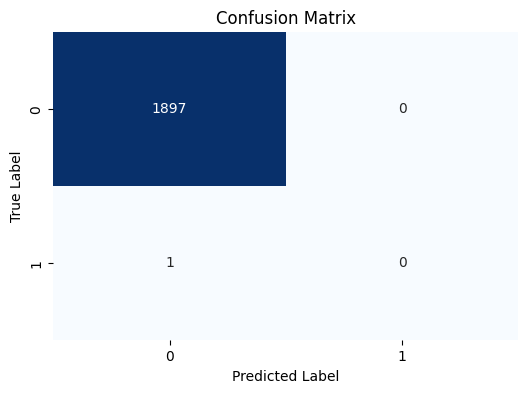


AUC-ROC Score: 0.9995


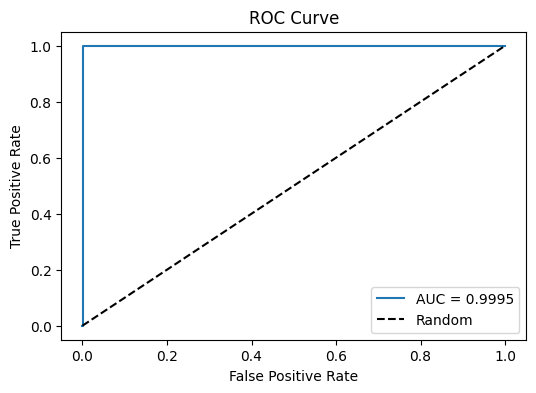

In [9]:
# Predict on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # Probability of the positive class (fraudulent)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print AUC-ROC score
auc_roc = roc_auc_score(y_test, y_prob)
print(f"\nAUC-ROC Score: {auc_roc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Logistic Regression model trained successfully with adjusted class weights!

Classification Report (with adjusted class weights):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1897
           1       0.00      0.00      0.00         1

    accuracy                           1.00      1898
   macro avg       0.50      0.50      0.50      1898
weighted avg       1.00      1.00      1.00      1898


Confusion Matrix (with adjusted class weights):


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


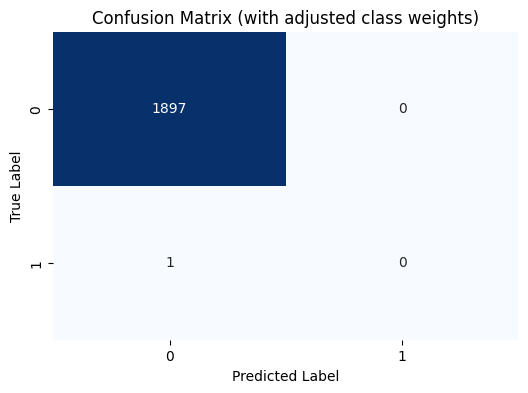


AUC-ROC Score (with adjusted class weights): 0.9995


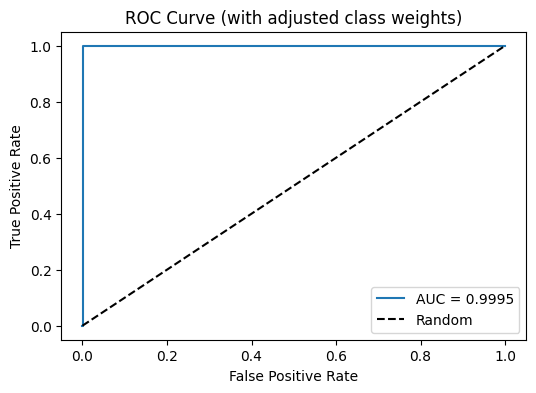

In [10]:
# Create the full pipeline with preprocessing and the model, adjusting class weights
model_with_weights = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))])

# Train the model with adjusted class weights
model_with_weights.fit(X_train, y_train)

print("Logistic Regression model trained successfully with adjusted class weights!")

# Predict on the test set with the new model
y_pred_weighted = model_with_weights.predict(X_test)
y_prob_weighted = model_with_weights.predict_proba(X_test)[:, 1] # Probability of the positive class (fraudulent)

# Evaluate the model with adjusted class weights
print("\nClassification Report (with adjusted class weights):")
print(classification_report(y_test, y_pred_weighted))

print("\nConfusion Matrix (with adjusted class weights):")
cm_weighted = confusion_matrix(y_test, y_pred_weighted)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (with adjusted class weights)')
plt.show()

# Calculate and print AUC-ROC score (with adjusted class weights)
auc_roc_weighted = roc_auc_score(y_test, y_prob_weighted)
print(f"\nAUC-ROC Score (with adjusted class weights): {auc_roc_weighted:.4f}")

# Plot ROC curve (with adjusted class weights)
fpr_weighted, tpr_weighted, thresholds_weighted = roc_curve(y_test, y_prob_weighted)
plt.figure(figsize=(6, 4))
plt.plot(fpr_weighted, tpr_weighted, label=f'AUC = {auc_roc_weighted:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (with adjusted class weights)')
plt.legend()
plt.show()

RandomForestClassifier model trained successfully!

Classification Report (RandomForestClassifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1897
           1       0.00      0.00      0.00         1

    accuracy                           1.00      1898
   macro avg       0.50      0.50      0.50      1898
weighted avg       1.00      1.00      1.00      1898


Confusion Matrix (RandomForestClassifier):


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


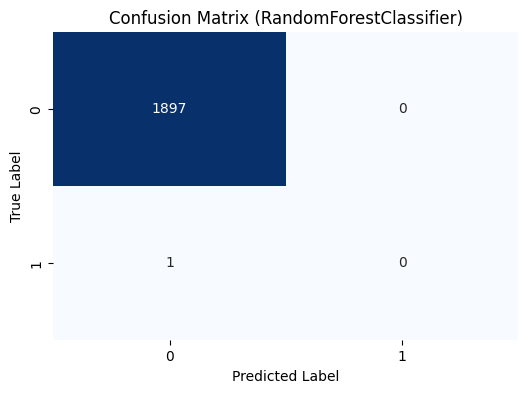


AUC-ROC Score (RandomForestClassifier): 0.9995


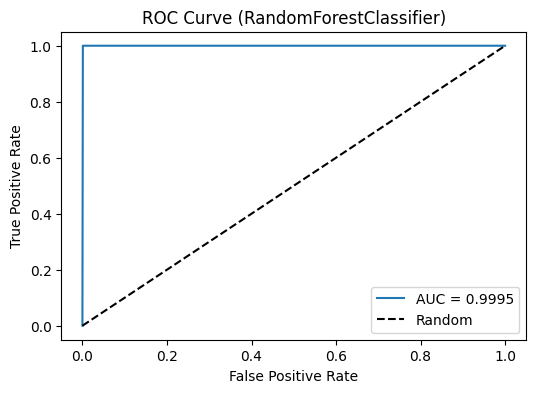

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Create the full pipeline with preprocessing and a RandomForestClassifier model
# We can still use class_weight='balanced' with RandomForestClassifier
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))])

# Train the RandomForestClassifier model
model_rf.fit(X_train, y_train)

print("RandomForestClassifier model trained successfully!")

# Predict on the test set with the RandomForestClassifier model
y_pred_rf = model_rf.predict(X_test)
y_prob_rf = model_rf.predict_proba(X_test)[:, 1] # Probability of the positive class (fraudulent)

# Evaluate the RandomForestClassifier model
print("\nClassification Report (RandomForestClassifier):")
print(classification_report(y_test, y_pred_rf))

print("\nConfusion Matrix (RandomForestClassifier):")
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (RandomForestClassifier)')
plt.show()

# Calculate and print AUC-ROC score (RandomForestClassifier)
auc_roc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"\nAUC-ROC Score (RandomForestClassifier): {auc_roc_rf:.4f}")

# Plot ROC curve (RandomForestClassifier)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f'AUC = {auc_roc_rf:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (RandomForestClassifier)')
plt.legend()
plt.show()


Predicted probabilities for the positive class (RandomForestClassifier):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Actual labels for the first 20 samples:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Analyzing the fraudulent transaction (index in original df: [5790]):


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_HOUR,TX_DAY_OF_WEEK,TX_DAY,TX_WEEK,TX_MONTH,TX_YEAR,customer_tx_count,terminal_tx_count
5790,5790,2018-04-01 13:31:48,4944,6050,222.26,48708,0,1,1,13,6,1,13,4,2018,2,1



Predicted probability for the fraudulent transaction: 0.0600

Features for the fraudulent transaction:


,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_HOUR,TX_DAY_OF_WEEK,TX_DAY,TX_WEEK,TX_MONTH,TX_YEAR,customer_tx_count,terminal_tx_count
5790,4944,6050,222.26,13,6,1,13,4,2018,2,1



Classification Report with threshold = 0.1:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1897
           1       0.00      0.00      0.00         1

    accuracy                           1.00      1898
   macro avg       0.50      0.50      0.50      1898
weighted avg       1.00      1.00      1.00      1898


Confusion Matrix with threshold = 0.1:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


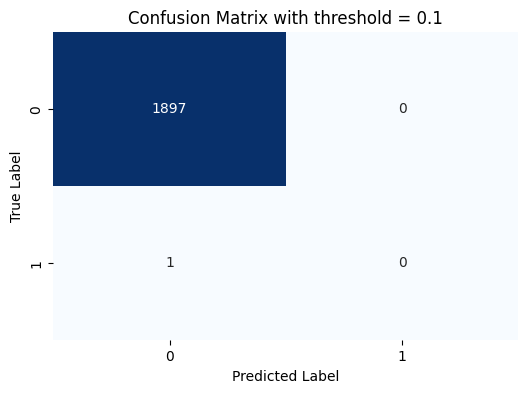

In [12]:
# Analyze predicted probabilities for the positive class (fraudulent)
print("\nPredicted probabilities for the positive class (RandomForestClassifier):")
print(y_prob_rf[:20]) # Display first 20 probabilities

# Let's look at the actual labels for these first 20 samples
print("\nActual labels for the first 20 samples:")
print(y_test.head(20).values)

# We can also examine the predicted probabilities specifically for the fraudulent transaction in the test set
# Find the index of the fraudulent transaction in the test set
fraud_index_in_test = y_test[y_test == 1].index

if not fraud_index_in_test.empty:
    print(f"\nAnalyzing the fraudulent transaction (index in original df: {fraud_index_in_test.tolist()}):")
    # Get the corresponding data from the original DataFrame using the original index
    fraud_transaction_data = df.loc[fraud_index_in_test]
    display(fraud_transaction_data)

    # Get the predicted probability for this fraudulent transaction
    # Need to find the corresponding index in the X_test and y_test split
    # This requires mapping the original index to the split index
    # A simpler approach for now is to find the probability by matching the transaction ID or another unique identifier if available and not used as a feature
    # Since TRANSACTION_ID was excluded, let's find the index in X_test that corresponds to the original index of the fraudulent transaction
    try:
        # Get the index in X_test that corresponds to the first fraudulent transaction in the original df
        # This assumes the order is preserved during splitting for demonstration, which is not always guaranteed.
        # A more robust way would involve merging or using a transaction ID if it were a feature or index.
        # Given it's a single example, let's find its location in the test set based on its original index.
        index_in_X_test = X_test.index.get_loc(fraud_index_in_test[0])
        fraud_prob_rf = y_prob_rf[index_in_X_test]
        print(f"\nPredicted probability for the fraudulent transaction: {fraud_prob_rf:.4f}")

        # We can also look at the features for this fraudulent transaction
        print("\nFeatures for the fraudulent transaction:")
        display(X_test.loc[fraud_index_in_test])

    except KeyError:
         print("\nCould not find the fraudulent transaction in the test set for detailed analysis of predicted probability and features.")
         print("This might happen if the test set was re-indexed or shuffled in a way that doesn't preserve the original index for easy lookup.")


else:
    print("\nNo fraudulent transactions found in the test set.")

# Example of trying a different threshold (e.g., 0.1)
# You would typically tune this threshold based on your specific needs (e.g., minimizing false negatives vs. false positives)
threshold = 0.1
y_pred_thresholded = (y_prob_rf >= threshold).astype(int)

print(f"\nClassification Report with threshold = {threshold}:")
print(classification_report(y_test, y_pred_thresholded))

print(f"\nConfusion Matrix with threshold = {threshold}:")
cm_thresholded = confusion_matrix(y_test, y_pred_thresholded)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_thresholded, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix with threshold = {threshold}')
plt.show()

In [14]:
# Analyze transactions based on a known fraud rule (TX_AMOUNT > 220)

# Identify transactions in the original DataFrame where TX_AMOUNT > 220
high_amount_transactions = df[df['TX_AMOUNT'] > 220]

print("\nTransactions with TX_AMOUNT > 220 (based on a known fraud rule):")
display(high_amount_transactions)

if not high_amount_transactions.empty:
    # Get the features for these high amount transactions
    X_high_amount = high_amount_transactions[features]

    # Use the trained RandomForestClassifier model to predict probabilities for these transactions
    # Use the pipeline's predict_proba directly on the raw features
    high_amount_prob_rf = model_rf.predict_proba(X_high_amount)[:, 1]

    print("\nPredicted probabilities (RandomForestClassifier) for transactions with TX_AMOUNT > 220:")
    # Display the original transactions along with their predicted probabilities
    # Create a copy to avoid SettingWithCopyWarning
    high_amount_transactions_with_prob = high_amount_transactions.copy()
    high_amount_transactions_with_prob['predicted_fraud_probability'] = high_amount_prob_rf
    display(high_amount_transactions_with_prob[['TX_AMOUNT', 'TX_FRAUD', 'predicted_fraud_probability']])

    # You can also see how many of these the model would classify as fraud with a certain threshold
    threshold_to_check = 0.5 # Using the default threshold for demonstration
    high_amount_predictions_thresholded = (high_amount_prob_rf >= threshold_to_check).astype(int)
    print(f"\nNumber of transactions with TX_AMOUNT > 220 predicted as fraud with threshold {threshold_to_check}:")
    print(sum(high_amount_predictions_thresholded))

    # Let's check with a lower threshold as well, say 0.1
    threshold_to_check_lower = 0.1
    high_amount_predictions_thresholded_lower = (high_amount_prob_rf >= threshold_to_check_lower).astype(int)
    print(f"\nNumber of transactions with TX_AMOUNT > 220 predicted as fraud with threshold {threshold_to_check_lower}:")
    print(sum(high_amount_predictions_thresholded_lower))


else:
    print("\nNo transactions found with TX_AMOUNT > 220 in the dataset.")


Transactions with TX_AMOUNT > 220 (based on a known fraud rule):


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_HOUR,TX_DAY_OF_WEEK,TX_DAY,TX_WEEK,TX_MONTH,TX_YEAR,customer_tx_count,terminal_tx_count
3527,3527,2018-04-01 10:17:43,3774,3059,225.41,37063,0,1,1,10,6,1,13,4,2018,6,2
5790,5790,2018-04-01 13:31:48,4944,6050,222.26,48708,0,1,1,13,6,1,13,4,2018,2,1
6549,6549,2018-04-01 14:42:02,4625,9102,226.40,52922,0,1,1,14,6,1,13,4,2018,4,3



Predicted probabilities (RandomForestClassifier) for transactions with TX_AMOUNT > 220:


,TX_AMOUNT,TX_FRAUD,predicted_fraud_probability
3527,225.41,1,0.66
5790,222.26,1,0.06
6549,226.40,1,0.60



Number of transactions with TX_AMOUNT > 220 predicted as fraud with threshold 0.5:
2

Number of transactions with TX_AMOUNT > 220 predicted as fraud with threshold 0.1:
2
